In [46]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score
import getpass  
password = getpass.getpass()

········


In [6]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = ''' 
select f.title,f.rental_duration,f.release_year,f.rental_rate,f.rating,fm.category_id
from film as f 
left join film_category as fm
on f.film_id=fm.film_id;'''

data = pd.read_sql_query(query, engine)
data.head()
data.tail()

,title,rental_duration,release_year,rental_rate,rating,category_id
995,YOUNG LANGUAGE,6,2006,0.99,G,6
996,YOUTH KICK,4,2006,0.99,NC-17,12
997,ZHIVAGO CORE,6,2006,0.99,NC-17,11
998,ZOOLANDER FICTION,5,2006,2.99,R,3
999,ZORRO ARK,3,2006,4.99,NC-17,5


In [7]:
#Create a query to get the total amount of rentals in June for each film.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = ''' 
select f.title,sum(p.amount) as total_amount
from  film as f
left join inventory as i
on f.film_id=i.film_id
left join rental as r
on i.inventory_id=r.inventory_id
left join payment as p
on r.rental_id=p.rental_id
where DATE_FORMAT(rental_date,'%%Y')=2005 and DATE_FORMAT(rental_date,'%%m')=6
group by f.title;
'''
data1 = pd.read_sql_query(query, engine)
data1.head()
data1.tail()

,title,total_amount
895,YOUNG LANGUAGE,0.99
896,YOUTH KICK,3.99
897,ZHIVAGO CORE,3.98
898,ZOOLANDER FICTION,6.98
899,ZORRO ARK,31.95


In [8]:
#Do the same with July.
#Create a query to get the total amount of rentals in June for each film.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = ''' 
select f.title,sum(p.amount) as total_amount
from  film as f
left join inventory as i
on f.film_id=i.film_id
left join rental as r
on i.inventory_id=r.inventory_id
left join payment as p
on r.rental_id=p.rental_id
where DATE_FORMAT(rental_date,'%%Y')=2005 and DATE_FORMAT(rental_date,'%%m')=7
group by f.title;
'''
data2 = pd.read_sql_query(query, engine)
data2.head()
data2.tail()


,title,total_amount
953,YOUNG LANGUAGE,2.97
954,YOUTH KICK,4.98
955,ZHIVAGO CORE,2.97
956,ZOOLANDER FICTION,28.93
957,ZORRO ARK,91.88


In [9]:
#Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June. Your objective will be to predict this new column.
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = ''' 
select f.title,sum(p.amount) as total_amount,DATE_FORMAT(rental_date,'%%m') as month
from  film as f
left join inventory as i
on f.film_id=i.film_id
left join rental as r
on i.inventory_id=r.inventory_id
left join payment as p
on r.rental_id=p.rental_id
where DATE_FORMAT(rental_date,'%%Y')=2005
and (DATE_FORMAT(rental_date,'%%m')=6 or DATE_FORMAT(rental_date,'%%m')=7)
group by f.title,DATE_FORMAT(rental_date,'%%m');''' 

data3 = pd.read_sql_query(query, engine)
data3.head()


,title,total_amount,month
0,ACADEMY DINOSAUR,10.91,07
1,ACADEMY DINOSAUR,3.97,06
2,ACE GOLDFINGER,14.98,07
3,ADAPTATION HOLES,11.96,07
4,ADAPTATION HOLES,2.99,06


In [10]:
# make table with month and total amount
df=data3.pivot_table(index=['title'],columns=['month'],values=['total_amount'],aggfunc=['sum']).reset_index()

df.columns = df.columns.droplevel(0)
df.columns = df.columns.droplevel(0)
df=df.rename(columns={'':'title'})

In [11]:
df

month,title,06,07
0,ACADEMY DINOSAUR,3.97,10.91
1,ACE GOLDFINGER,NaN,14.98
2,ADAPTATION HOLES,2.99,11.96
3,AFFAIR PREJUDICE,5.98,48.88
4,AFRICAN EGG,8.98,23.95
...,...,...,...
953,YOUNG LANGUAGE,0.99,2.97
954,YOUTH KICK,3.99,4.98
955,ZHIVAGO CORE,3.98,2.97
956,ZOOLANDER FICTION,6.98,28.93


In [12]:
#Creat column yes/no for this table 
df['Yes/NO'] = np.where((df['06'] >= df['07']), "NO", "yes")
df[df['Yes/NO'].isnull()]
df=df.drop('06', axis=1)
df=df.drop('07', axis=1)


In [15]:
# join table df with my main table

data= pd.merge(left = data, 
                                 right = df, 
                                 how = 'left', 
                                 left_on = "title", 
                                 right_on= "title") 

data

,title,rental_duration,release_year,rental_rate,rating,category_id,Yes/NO
0,ACADEMY DINOSAUR,6,2006,0.99,PG,6,yes
1,ACE GOLDFINGER,3,2006,4.99,G,11,yes
2,ADAPTATION HOLES,7,2006,2.99,NC-17,6,yes
3,AFFAIR PREJUDICE,5,2006,2.99,G,11,yes
4,AFRICAN EGG,6,2006,2.99,G,8,yes
...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,6,2006,0.99,G,6,yes
996,YOUTH KICK,4,2006,0.99,NC-17,12,yes
997,ZHIVAGO CORE,6,2006,0.99,NC-17,11,NO
998,ZOOLANDER FICTION,5,2006,2.99,R,3,yes


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1000 non-null   object 
 1   rental_duration  1000 non-null   int64  
 2   release_year     1000 non-null   int64  
 3   rental_rate      1000 non-null   float64
 4   rating           1000 non-null   object 
 5   category_id      1000 non-null   int64  
 6   Yes/NO           958 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 62.5+ KB


In [17]:
#Changing the data type of differnt columns
data['rental_duration'] = data['rental_duration'].astype('object')
data['release_year'] = data['release_year'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')
data['category_id'] = data['category_id'].astype('object')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1000 non-null   object
 1   rental_duration  1000 non-null   object
 2   release_year     1000 non-null   object
 3   rental_rate      1000 non-null   object
 4   rating           1000 non-null   object
 5   category_id      1000 non-null   object
 6   Yes/NO           958 non-null    object
dtypes: object(7)
memory usage: 62.5+ KB


In [19]:
data[data['Yes/NO'].isnull()]
data = data[data['Yes/NO'].isna() == False]
data.reset_index()

,index,title,rental_duration,release_year,rental_rate,rating,category_id,Yes/NO
0,0,ACADEMY DINOSAUR,6,2006,0.99,PG,6,yes
1,1,ACE GOLDFINGER,3,2006,4.99,G,11,yes
2,2,ADAPTATION HOLES,7,2006,2.99,NC-17,6,yes
3,3,AFFAIR PREJUDICE,5,2006,2.99,G,11,yes
4,4,AFRICAN EGG,6,2006,2.99,G,8,yes
...,...,...,...,...,...,...,...,...
953,995,YOUNG LANGUAGE,6,2006,0.99,G,6,yes
954,996,YOUTH KICK,4,2006,0.99,NC-17,12,yes
955,997,ZHIVAGO CORE,6,2006,0.99,NC-17,11,NO
956,998,ZOOLANDER FICTION,5,2006,2.99,R,3,yes


In [50]:
data.isna().sum()

title              0
rental_duration    0
release_year       0
rental_rate        0
rating             0
category_id        0
Yes/NO             0
dtype: int64

In [20]:
#display(data[data['Yes/NO']=='NO']).counts_value()

data['Yes/NO'].value_counts()

yes    934
NO      24
Name: Yes/NO, dtype: int64

In [21]:
#Checking the Number of Values in each columns
data['rental_duration'].value_counts()
data['release_year'].value_counts()  # had one vlue so we remove it from our data
data.drop('release_year' ,axis=1)
data['rental_rate'].value_counts()
data['rating'].value_counts()
data['category_id'].value_counts()

15    73
8     67
9     67
2     64
6     63
1     61
7     61
13    60
14    59
10    58
3     58
5     56
4     54
11    53
16    53
12    51
Name: category_id, dtype: int64

In [22]:
#Build X and y
y = data['Yes/NO']
X = data.drop(['Yes/NO'], axis=1)
X = X.drop(['title'], axis=1)

In [34]:
display(X)

,rental_duration,release_year,rental_rate,rating,category_id
0,6,2006,0.99,PG,6
1,3,2006,4.99,G,11
2,7,2006,2.99,NC-17,6
3,5,2006,2.99,G,11
4,6,2006,2.99,G,8
...,...,...,...,...,...
995,6,2006,0.99,G,6
996,4,2006,0.99,NC-17,12
997,6,2006,0.99,NC-17,11
998,5,2006,2.99,R,3


In [24]:
#Split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [36]:
# dummy the categoricals-Train
X_train_transformed= pd.get_dummies(X_train, 
                             columns=['rental_duration','release_year','rental_rate','rating','category_id'],
                             drop_first=True)
X_train_transformed.head()

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
605,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
568,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
615,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
785,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# dummy the categoricals-Test
X_test_transformed= pd.get_dummies(X_test, 
                             columns=['rental_duration','release_year','rental_rate','rating','category_id'],
                             drop_first=True)
X_test_transformed.head()

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R,...,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16
211,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
335,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
662,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

Ir = LogisticRegression(random_state=0, solver='lbfgs')
Ir.fit(X_train_transformed, y_train)

LogisticRegression(random_state=0)

In [65]:
y_train_pred = classification.predict(X_train_transformed)
y_pred_test = classification.predict(X_test_transformed)

In [66]:
# Chexk Errores
#accuracy
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))

#Precission
print("The precission in the TRAIN set is: {:.3f}".format(precision_score(y_train, y_train_pred, pos_label="yes")))
print("The precission in the TEST  set is: {:.3f}".format(precision_score(y_test, y_test_pred, pos_label="yes")))

#Recall
print("The recall in the TRAIN set is: {:.3f}".format(recall_score(y_train, y_train_pred, pos_label="yes")))
print("The recall in the TEST  set is: {:.3f}".format(recall_score(y_test,  y_test_pred, pos_label="yes")))
#f1_score
print("The F1-score for the TRAIN set is {:.2f}".format(f1_score(y_train,y_train_pred, pos_label="yes")))
#Kappa
print("The kappa in the TRAIN- set is: {:.2f}".format(cohen_kappa_score(y_train,y_train_pred)))
print("The kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TRAIN set is: 0.969
The accuracy in the TEST  set is: 1.000
The precission in the TRAIN set is: 0.969
The precission in the TEST  set is: 1.000
The recall in the TRAIN set is: 1.000
The recall in the TEST  set is: 1.000
The F1-score for the TRAIN set is 0.98
The kappa in the TRAIN- set is: 0.00
The kappa in the TEST set is: nan


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


The confusion matrix on the TRAIN set is: 


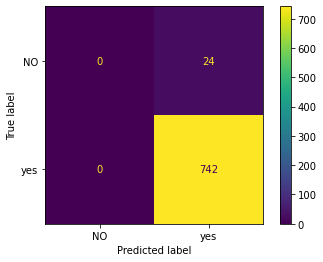

In [72]:
print("The confusion matrix on the TRAIN set is: ")
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train
disp = ConfusionMatrixDisplay(cm_train,display_labels=Ir.classes_);
disp.plot()
plt.show()
# I couldn't perdict the No Value in our column because the Number of "No" Comparing to "Yes" is very low 